In [1]:
# 导入必要的包
import torch
import torch
import torchvision as tv
from torchvision import transforms as tfs
import torch.nn as nn
import torch.optim as optim

# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 3),
            nn.ELU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.ELU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2), 
            nn.Dropout(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ELU(),
            nn.BatchNorm2d(64)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.25)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ELU(),
            nn.BatchNorm2d(128)
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.25)
        )
       
        self.fc1 = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ELU()
        )
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [3]:
img_aug = tfs.Compose([
        #tfs.Resize(120),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(28),
        tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
batch_size = 128
trainset = tv.datasets.CIFAR10(root='./data/cifa10', train=True,download=False, transform=img_aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testset = tv.datasets.CIFAR10(root='./data/cifa10', train=False,download=False, transform=img_aug)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

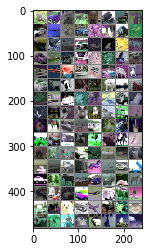

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
img, label = dataiter.next()
imshow(tv.utils.make_grid(img))

In [9]:
lr = 0.001
epochs = 50
net = CNN().to(device)
loss = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr = lr, weight_decay = 0.0001)

schedule = optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 5)
train_loss = []
test_loss = []
dataIter = iter(testloader)
for epoch in range(epochs):
    sum_loss = 0.
    for i, (img, label) in enumerate(trainloader):
        img, label = img.to(device), label.to(device)
        opt.zero_grad()
        out = net(img)
        L = loss(out, label)
        L.backward()
        opt.step()
        schedule.step(epoch)
        sum_loss += L.item()
        
        if i % 100 == 99:
            train_loss.append(sum_loss / 100)
            tloss = 0
            Iter = testloader.__iter__()
            img_test, label_test = Iter.next()
            tloss = loss(net(img_test.to(device)), label_test.to(device)).item()
            test_loss.append(tloss)
            print('[%d, %d] train_loss: %.03f test_loss: %.03f'
                      % (epoch + 1, i + 1, sum_loss / 100, tloss))
            sum_loss = 0.0
            del(Iter)
            
    with torch.no_grad():
        correct = 0
        total = 0
        flag = False
        for img, label in testloader:
            img, label = img.to(device), label.to(device)
            out = net(img)
            if flag == False:
                L = loss(out, label)
                test_loss.append(L)
                flag = True
            _, ypred = torch.max(out.data, 1)
            total += label.size(0)
            correct += (ypred == label).sum()
        print('第%d个epoch的识别准确率为：%d%%' % (epoch + 1, (100 * correct / total)))

[1, 100] train_loss: 2.115 test_loss: 1.777
[1, 200] train_loss: 1.675 test_loss: 1.480
[1, 300] train_loss: 1.435 test_loss: 1.323
第1个epoch的识别准确率为：55%
[2, 100] train_loss: 1.204 test_loss: 0.995
[2, 200] train_loss: 1.149 test_loss: 0.978
[2, 300] train_loss: 1.066 test_loss: 1.076
第2个epoch的识别准确率为：64%
[3, 100] train_loss: 0.960 test_loss: 0.859
[3, 200] train_loss: 0.937 test_loss: 1.005
[3, 300] train_loss: 0.901 test_loss: 0.840
第3个epoch的识别准确率为：69%
[4, 100] train_loss: 0.834 test_loss: 0.666
[4, 200] train_loss: 0.802 test_loss: 0.752
[4, 300] train_loss: 0.802 test_loss: 0.730
第4个epoch的识别准确率为：71%
[5, 100] train_loss: 0.746 test_loss: 0.661
[5, 200] train_loss: 0.733 test_loss: 0.662
[5, 300] train_loss: 0.729 test_loss: 0.759
第5个epoch的识别准确率为：73%
[6, 100] train_loss: 0.715 test_loss: 0.641
[6, 200] train_loss: 0.718 test_loss: 0.668
[6, 300] train_loss: 0.695 test_loss: 0.764
第6个epoch的识别准确率为：73%
[7, 100] train_loss: 0.701 test_loss: 0.701
[7, 200] train_loss: 0.722 test_loss: 0.763


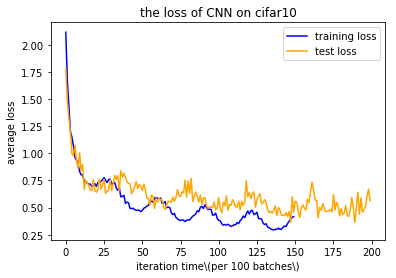

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_loss, c = "blue", label = "training loss")
plt.plot(test_loss, c = "orange", label = "test loss")
plt.title("the loss of CNN on cifar10")
plt.xlabel("iteration time\(per 100 batches\)")
plt.ylabel("average loss")
plt.legend(loc = "upper right")
plt.show()

In [13]:
torch.save(net, './model/CNN.pkl')

D:\Ananconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Ananconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Ananconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Ananconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ELU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Ananconda\lib\site-packages\torch\serialization.py:292: UserWar

In [12]:
print(net)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool